In [1697]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import optax
import jax
import jax.numpy as jnp

import fncs as fn

In [1698]:
importlib.reload(fn)

<module 'fncs' from '/Users/lucaraffo/Desktop/codes/fncs.py'>

In [1699]:
def mask_threshold(M: jnp.ndarray, t: float) -> jnp.ndarray:


    mask = (jnp.abs(M) >= t).astype(M.dtype)
    
    return M * mask

In [1700]:
seed = 5
d = 8
n_spins = d
p = 0.3           # prob. di non-zero per ciascuna off-diagonale
minval, maxval = -1.0, 1.0  # magnitudine
diag_base = 1.0   # varianze di base sulla diagonale
eps = 1e-6

key = jax.random.PRNGKey(seed)
covariance = jnp.zeros((n_spins, n_spins))

for i in range(n_spins):
    for j in range(0, i):
        key, k_u, k_mag, k_sgn = jax.random.split(key, 4)
        u = jax.random.uniform(k_u)
        if u < p:
            mag = jax.random.uniform(k_mag, minval=minval, maxval=maxval)
            sgn = jnp.where(jax.random.bernoulli(k_sgn, 0.5), 1.0, -1.0)
            val = sgn * mag
            covariance = covariance.at[i, j].set(val)
            covariance = covariance.at[j, i].set(val)

# diagonale di base (mantiene la sparsità off-diagonale)
Sigma_true = covariance + diag_base * jnp.eye(n_spins)

In [1701]:
# synthetic data
#rng = np.random.default_rng(5673)
#d = 8
#A = rng.normal(size=(d, d))
#Sigma_true = A @ A.T + 0.1 * np.eye(d)
n = 500
X_np = rng.multivariate_normal(mean=np.zeros(d), cov=Sigma_true, size=n)

/var/folders/gd/b2d40bms7s3f8y4f31x7pk1r0000gn/T/ipykernel_55662/526476003.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X_np = rng.multivariate_normal(mean=np.zeros(d), cov=Sigma_true, size=n)


In [1702]:
# score matching baseline
Sigma_sm = np.array(fn.score_matching_cov_zero_mean(jnp.asarray(X_np), ridge=1e-8))

In [1703]:
print("||Sigma_sm - Sigma_true||_F/||Sigma_true||_F:", np.linalg.norm(Sigma_sm   - Sigma_true, 'fro')/np.linalg.norm(Sigma_true, 'fro'))

||Sigma_sm - Sigma_true||_F/||Sigma_true||_F: 0.3635071


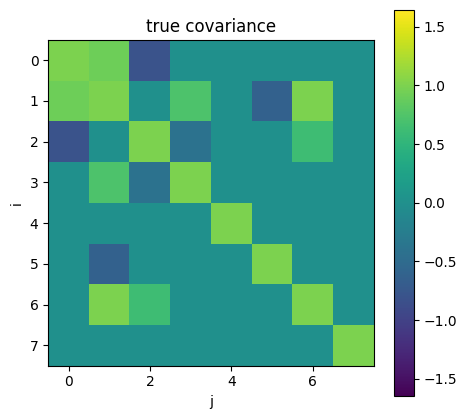

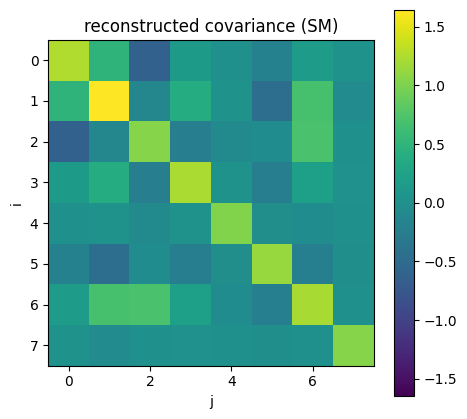

In [1704]:
fn.plot_cov_heatmaps(Sigma_true, Sigma_sm,
                  title_true="true covariance",
                  title_rec ="reconstructed covariance (SM)")

In [1705]:
# w-grad MMD (RBF)
Sigma_rbf, theta_rbf, hist_rbf, Sigma_noise_rbf = fn.fit_cov_by_wgrad_mmd_jax(
    X_np, kernel="rbf", sigma_rbf="median",
    n_model=n, seed_samples=7,
    iters=250, lr=5e-2, init_from_noisy_inverse=False
)

In [1706]:
print("||Sigma_rbf - Sigma_true||_F/||Sigma_true||_F:", np.linalg.norm(Sigma_rbf - Sigma_true, 'fro')/np.linalg.norm(Sigma_true, 'fro'))

||Sigma_rbf - Sigma_true||_F/||Sigma_true||_F: 0.5449738


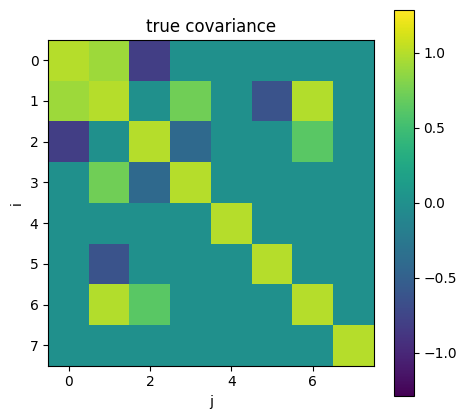

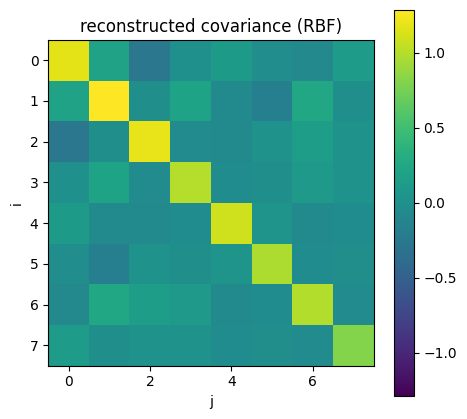

In [1707]:
fn.plot_cov_heatmaps(Sigma_true, Sigma_rbf,
                  title_true="true covariance",
                  title_rec ="reconstructed covariance (RBF)")

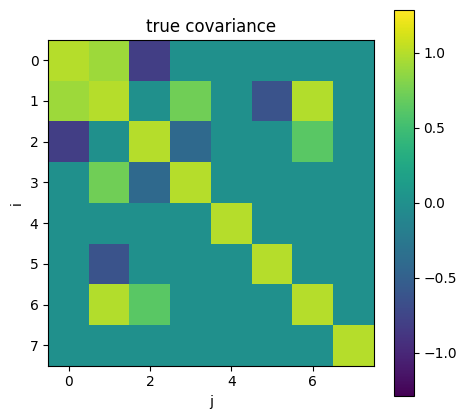

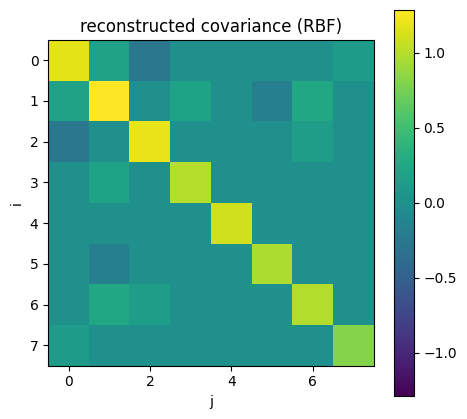

In [1708]:
fn.plot_cov_heatmaps(mask_threshold(Sigma_true, 0.12), mask_threshold(Sigma_rbf, 0.12),
                  title_true="true covariance",
                  title_rec ="reconstructed covariance (RBF)")

In [1709]:
# w-grad MMD (Polynomial, degree 2)
Sigma_poly, theta_poly, hist_poly, Sigma_noise_poly = fn.fit_cov_by_wgrad_mmd_jax(
    X_np, kernel="poly", degree=2, c=1.0,
    n_model=n, seed_samples=11,
    iters=250, lr=5e-2, init_from_noisy_inverse=False
)

In [1710]:
print("||Sigma_poly - Sigma_true||_F/||Sigma_true||_F:", np.linalg.norm(Sigma_poly - Sigma_true, 'fro') / np.linalg.norm(Sigma_true, 'fro'))

||Sigma_poly - Sigma_true||_F/||Sigma_true||_F: 0.5211447


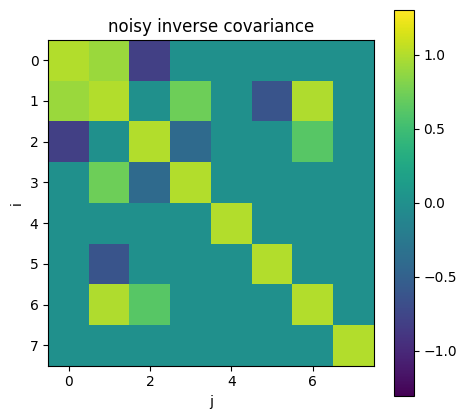

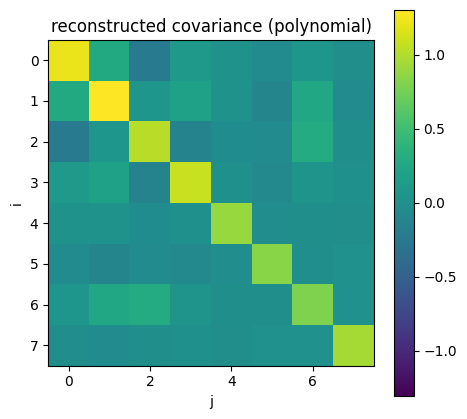

In [1711]:
fn.plot_cov_heatmaps(Sigma_true, Sigma_poly,
                  title_true="noisy inverse covariance",
                  title_rec ="reconstructed covariance (polynomial)")

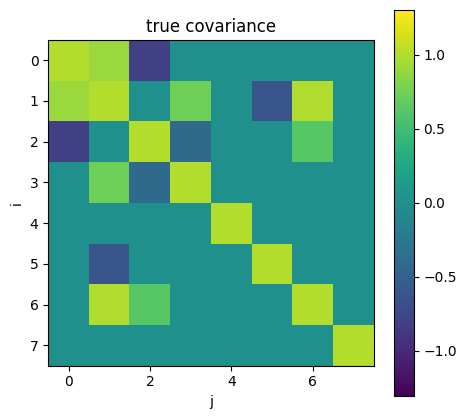

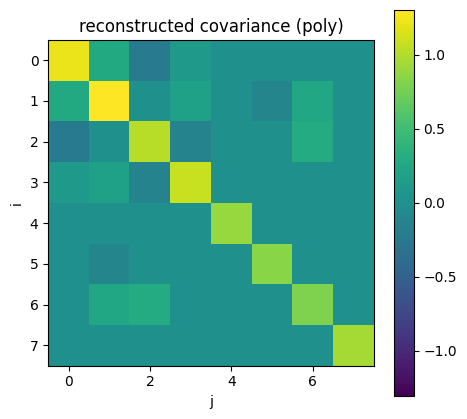

In [1712]:
fn.plot_cov_heatmaps(mask_threshold(Sigma_true, 0.08), mask_threshold(Sigma_poly, 0.08),
                  title_true="true covariance",
                  title_rec ="reconstructed covariance (poly)")